In [ ]:
from sklearn.datasets import make_classification
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model


In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [7]:
X2=np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])

In [9]:
TSNE(n_components=2,init='random').fit_transform(X2)

array([[256.11038, 257.60544],
       [295.5285 , 189.36717],
       [241.70055, 203.77661],
       [309.93933, 243.19446]], dtype=float32)

In [10]:
ddf = pd.read_csv('all_faults.csv')

In [11]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len=1000
stride=200

X=[]
Y=[]


for k in ddf['fault'].unique():
    
    df_temp_2 = ddf[ddf['fault']==k]
    
    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])
    
X=np.array(X)
X=X.reshape((X.shape[0],win_len))



Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [13]:
np.shape(X)
encoder.classes_

array(['Trial_112', 'Trial_113', 'Trial_114', 'Trial_116', 'Trial_117',
       'Trial_118', 'trial_111', 'trial_115'], dtype='<U9')

In [14]:
X[0]

array([ 2.1140920e-01,  2.0000000e-01,  1.7990224e-01,  1.9301009e-01,
        2.2547908e-01,  1.3612925e-01,  8.9349844e-02,  1.5392706e-01,
        7.2634332e-02, -7.7805318e-02,  3.5836142e-02,  1.4358509e-01,
        1.0474255e-01, -1.7509203e-01, -2.3353620e-01,  3.3671540e-03,
       -7.4077398e-02, -2.5061250e-01, -1.1520478e-01, -1.1496427e-01,
       -4.5576841e-02,  1.4310406e-02,  3.2216451e-01,  3.0797437e-01,
        4.7861695e-02,  1.0257795e-01,  2.4171358e-02, -2.0287105e-01,
       -1.3829383e-01,  2.3185262e-01, -3.4513332e-02, -4.9364889e-01,
       -2.6576468e-01, -1.8940243e-01, -2.9558805e-01, -3.1374663e-01,
       -3.6846289e-01, -4.8559177e-01,  7.1792543e-02,  4.6983829e-01,
        3.7435541e-01,  2.5518221e-01,  6.0175860e-01,  4.5167971e-01,
        1.6390826e-01,  2.8596762e-01,  3.5042456e-01,  3.0893642e-01,
        3.8794428e-01,  3.4272820e-01,  1.0570460e-01,  1.6378801e-01,
        2.7827126e-01, -2.2547908e-01, -3.8650122e-01, -5.5317530e-03,
      

In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [16]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10529, 1000)
(4513, 1000)
(10529, 8)
(4513, 8)


In [ ]:
X_pre_aen = X
X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(X_pre_aen )

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15042 samples in 3.311s...


In [ ]:
tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['t-SNE component 1', 't-SNE component 2'])
tSNEdf['Fault']=Y

In [ ]:
# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(x=tSNEdf['t-SNE component 1'],y=tSNEdf['t-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [ ]:
tSNEdf

In [ ]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten


# from tensorflow.keras.models import load_model
# AE_model = load_model(r'Trained Model\AE_model_gear.h5')


no_classes=len(encoder.classes_)
# build a model
model = Sequential()
model.add(Dense(1024, input_shape=(X.shape[1],), activation='relu')) # input shape is (features,)
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))
model.summary()

# compile the model
model.compile(optimizer='RMSprop', 
              loss='categorical_crossentropy', # this is different instead of binary_crossentropy (for regular classification)
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=50, # you can set this to a big number!
                    batch_size=32,
                    shuffle=True,
                    validation_data=(X_test,y_test),
                    verbose=1)

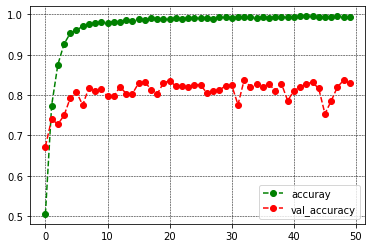

In [16]:
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['accuray','val_accuracy'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
model.save('model.h5')

In [17]:
y_pred=model.predict(X_test)
print(y_pred)
print(y_pred.shape)

[[0.00000000e+00 1.00000000e+00 0.00000000e+00 3.28348063e-37
  0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [7.97099888e-01 1.99315255e-03 1.08366869e-01 2.84943003e-02
  6.40458763e-02]
 ...
 [1.68234197e-04 2.84213526e-03 6.39162838e-01 2.72927707e-07
  3.57826501e-01]
 [0.00000000e+00 1.89615118e-33 1.00000000e+00 0.00000000e+00
  1.12812437e-29]
 [1.71464045e-23 3.77300400e-26 1.10475756e-35 1.00000000e+00
  5.41687302e-21]]
(2957, 5)


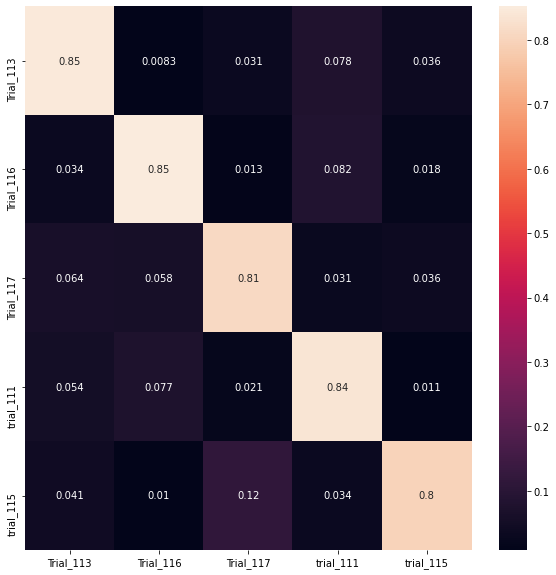

In [18]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred






Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.show()

In [19]:
dummy_ann = Model(inputs=model.input,outputs=model.layers[-2].output)
y_viz = dummy_ann.predict(X_train)
y_viz.shape

(6898, 128)

In [20]:
def T_SNE_plot(X_train,y_train,model,encoder):
    
    dummy_ann = Model(inputs=model.input,outputs=model.layers[-2].output)
    y_viz = dummy_ann.predict(X_train)
    
    from sklearn.manifold import TSNE

    X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

    tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

    tSNEdf['Fault']=inv_Transform_result(y_train)


    # Plot the PC-1 and PC-2
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
        data=tSNEdf,
        legend="full",
        alpha=0.3)
    plt.show()

C:\Users\abulf\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6898 samples in 0.016s...
[t-SNE] Computed neighbors for 6898 samples in 1.148s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6898
[t-SNE] Computed conditional probabilities for sample 2000 / 6898
[t-SNE] Computed conditional probabilities for sample 3000 / 6898
[t-SNE] Computed conditional probabilities for sample 4000 / 6898
[t-SNE] Computed conditional probabilities for sample 5000 / 6898
[t-SNE] Computed conditional probabilities for sample 6000 / 6898
[t-SNE] Computed conditional probabilities for sample 6898 / 6898
[t-SNE] Mean sigma: 7.617738
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.619194
[t-SNE] KL divergence after 300 iterations: 2.045338


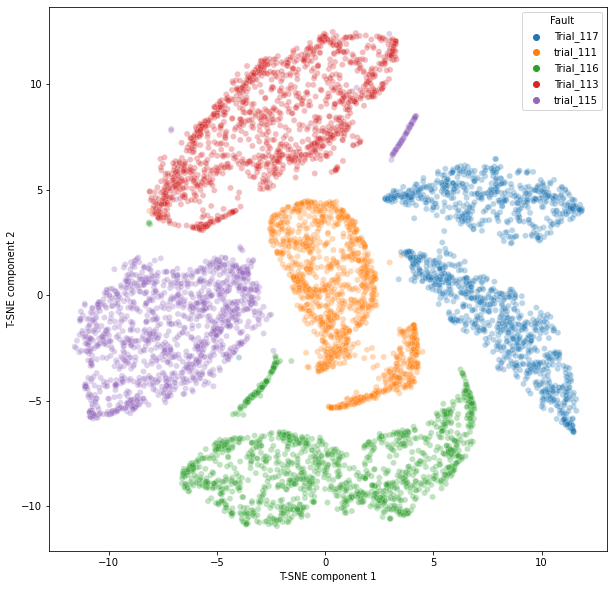

In [21]:
T_SNE_plot(X_train,y_train,model,encoder)

In [23]:

import pickle    

pickle.dump(y_pred, open('ANN_.pkl', 'wb')) 


In [25]:
from flask import Flask, render_template, request
model = pickle.load(open('ANN_.pkl', 'rb'))

app = Flask(__name__)

@app.route('/')
def man():
    return render_template('Project.html')

@app.route('/predict', methods=['POST'])
def home():
    data1 = request.form['acceleration']
    arr = DE_data
    pred = model.predict(arr)
    return render_template('after.html', data=pred)


if __name__ == "__main__":
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with windowsapi reloader


SystemExit: 1

C:\Users\abulf\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [25]:
#Column 1 
DE_data=ttk.Label(win,text="DE_data")
DE_data.grid(row=0,column=0,sticky=tk.W)
DE_data_var=tk.StringVar()
DE_data_entrybox=ttk.Entry(win,width=16,textvariable=DE_data_var)
DE_data_entrybox.grid(row=0,column=1)

In [26]:
import pandas as pd
ddf = pd.DataFrame()
def action():
    global DB
    import pandas as pd
    ddf = pd.DataFrame(columns=['DE_data'])
    DE_DATA=DE_data_var.get()
    ddf.loc[0,'DE_data']=DE_DATA
print(ddf.shape)
DB=ddf
def Output():
    DB["DE_data"] = pd.to_numeric(DB["DE_data"])

(0, 0)


In [ ]:
output=model.predict(DB)
    if output==[1]:
        result='Diabetic'
    elif output==0:
        result='Non-Diabetic'
    elif output==0:
        result='Non-Diabetic'
    elif output==0:
        result='Non-Diabetic'
    elif output==0:
        result='Non-Diabetic'

In [50]:
from tensorflow import keras
import tensorflow as tf
model = keras.models.load_model('model.h5')
# if used same model file, the mappings will remain same
mappings = ['Trial_113', 'Trial_116', 'Trial_117', 'trial_111', 'trial_115']
ddf = pd.read_csv('test.csv')
# taking first 1000 entries from file
x = np.array(ddf['vibrations'][:1000])
x = tf.expand_dims(x, 0)
out = np.array(model.predict(x))
out = np.where(out==np.max(out))
print(mappings[out[0][0]])

Trial_113
